# Wikipedia Network Analysis

This notebook contains modified code originally by Brian Keegan, Ph.D.  
https://github.com/brianckeegan/Wikipedia-Network-Analysis  
https://github.com/brianckeegan/wikifunctions

Released under a [CC-BY-SA 3.0 License](https://creativecommons.org/licenses/by-sa/3.0/).

In [1]:
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd
import numpy as np
from collections import Counter
from copy import deepcopy
from IPython.display import HTML

# Get outlinks from a page

In [2]:
def get_page_raw_content(page_title, endpoint='en.wikipedia.org/w/api.php', redirects=1):
    """Takes a page title and returns the raw HTML.

    page_title - a string with the title of the page on Wikipedia
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1

    Returns:
    outlinks_per_lang - a dictionary keyed by language returning a dictionary
        keyed by page title returning a list of outlinks
    """

    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    #req = requests.get('https://{2}.wikipedia.org/w/api.php?action=parse&format=json&page={0}&redirects={1}&prop=text&disableeditsection=1&disabletoc=1'.format(page_title,redirects,lang))
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'parse'
    query_params['page'] = page_title
    query_params['redirects'] = redirects
    query_params['prop'] = 'text'
    query_params['disableeditsection'] = 1
    query_params['disabletoc'] = 1
    query_params['format'] = 'json'
    query_params['formatversion'] = 2

    json_response = requests.get(url = query_url, params = query_params).json()

    if 'parse' in json_response.keys():
        markup = json_response['parse']['text']
        final_title = json_response['parse']['title']
    else:
        markup = str()
        final_title = page_title

    return markup


def parse_to_links(input,is_json=False):
    """Parses HTML or JSON to extract a list of outlinks.

    Args:
        input: The HTML or JSON content to parse.
        is_json: A boolean indicating whether the input is JSON.

    Returns:
        A list of outlinks.
    """
    # Initialize an empty list to store the links
    outlinks_list = []

    if is_json:
        page_html = input['parse']['text']#['*']
    else:
        page_html = input

    # Parse the HTML into Beautiful Soup
    soup = BeautifulSoup(page_html,'lxml')

    # Remove sections at end
    bad_sections = ['See_also','Notes','References','Bibliography','External_links']
    bad_titles = ['Special:','Wikipedia:','Help:','Template:','Category:','International Standard','Portal:','s:','File:','Digital object identifier','(page does not exist)']

    # For each paragraph tag, extract the titles within the links
    for para in soup.find_all('p'):
        for link in para.find_all('a'):
            if link.has_attr('title'):
                title = link['title']
                # Ignore links that aren't interesting or are redlinks
                if all(bad not in title for bad in bad_titles) and 'redlink' not in link['href']:
                    outlinks_list.append(title)

    # For each unordered list, extract the titles within the child links
    for unordered_list in soup.find_all('ul'):
        for item in unordered_list.find_all('li'):
            for link in item.find_all('a'):
                if link.has_attr('title'):
                    title = link['title']
                    # Ignore links that aren't interesting or are redlinks
                    if all(bad not in title for bad in bad_titles) and 'redlink' not in link['href']:
                        outlinks_list.append(title)

    return outlinks_list


In [3]:
retrieved_html = get_page_raw_content("University of Southern California")
ten_outlink_from_usc = parse_to_links(retrieved_html)[:10] + ["University of Southern California"]

In [4]:
ten_outlink_from_usc
ten_outlink_from_usc_2_step = ten_outlink_from_usc.copy()

In [5]:
for link in tqdm(ten_outlink_from_usc):
    retrieved_html = get_page_raw_content(link)
    ten_outlink_from_usc_2_step += parse_to_links(retrieved_html)[:10]

100%|██████████| 11/11 [00:10<00:00,  1.04it/s]


# Make a hyperlink network

In [6]:
def create_directed_graph(page_list):
  """
  Creates a directed graph based on outlinks from a list of pages.

  Args:
    page_list: A list of page names.

  Returns:
    A NetworkX DiGraph object representing the page network.
  """

  graph = nx.DiGraph()
  for page in tqdm(page_list):
    try:
      retrieved_html = get_page_raw_content(page)
      outlinks = parse_to_links(retrieved_html)
      for outlink in outlinks:
        if outlink in page_list:  # Check if the outlink is also in the page list
          graph.add_edge(page, outlink)
    except Exception as e:
      print(f"Error processing {page}: {e}")
  return graph

# Example usage:
G = create_directed_graph(ten_outlink_from_usc)

100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


In [7]:
G.nodes()

NodeView(('Private university', 'Graduate school', 'Research university', 'Postgraduate education', 'Los Angeles', 'California', 'University of Southern California', 'Robert Maclay Widney', 'University of Southern California academics', 'Undergraduate education', 'Liberal arts education'))

100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


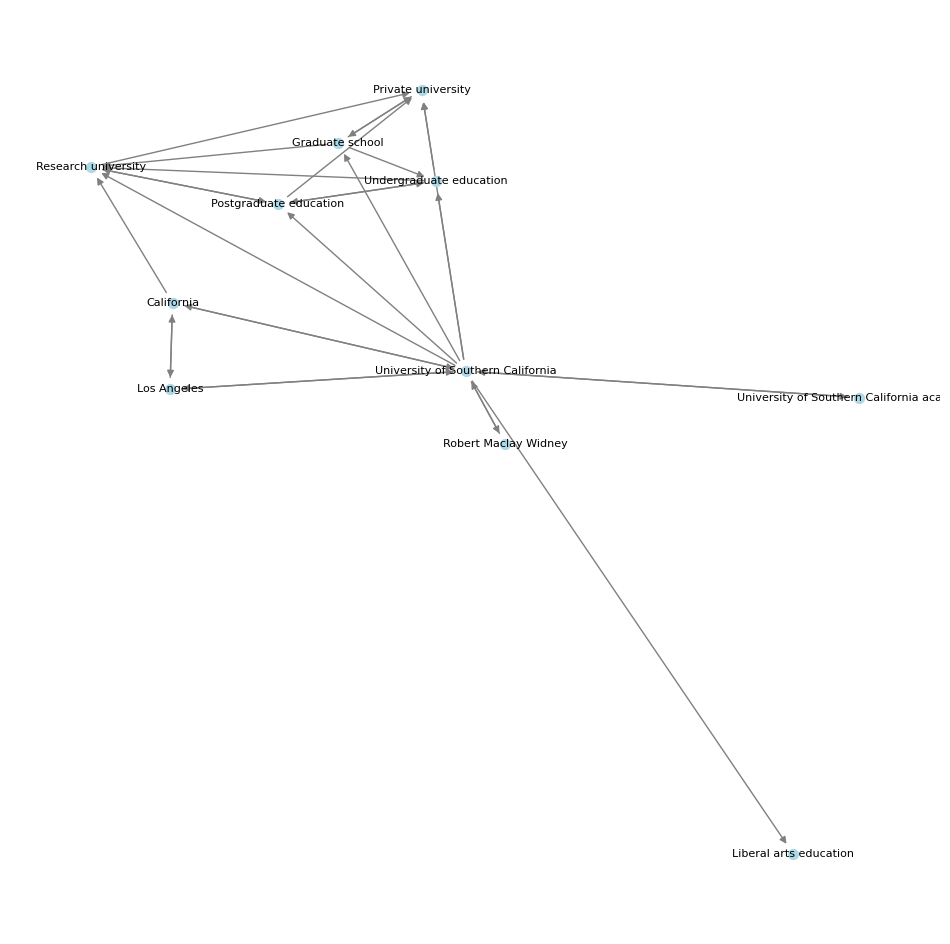

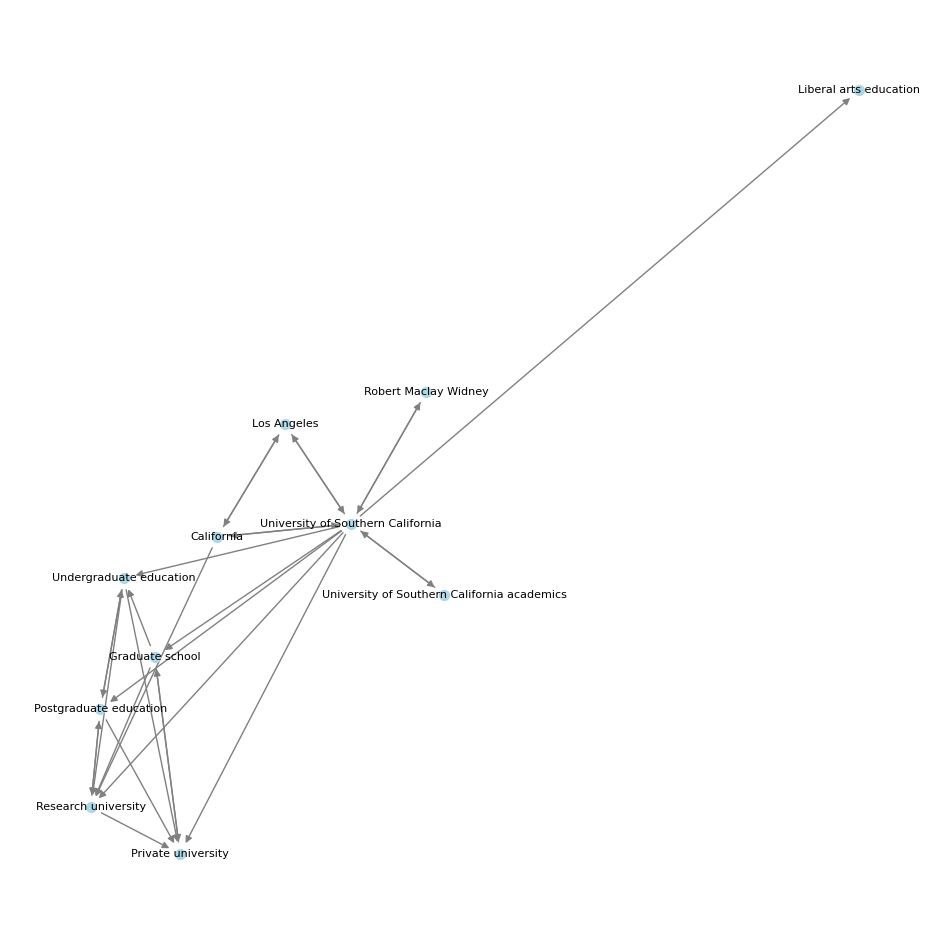

In [189]:
plt.figure(figsize=(12, 12))  # Adjust figure size as needed

pos = nx.spring_layout(G)  # You can experiment with different layout algorithms

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="lightblue")

nx.draw_networkx_edges(G, pos, edge_color="gray")

# Draw labels (optional, might be cluttered for large graphs)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis("off")
plt.show()


plt.figure(figsize=(12, 12))  # Adjust figure size as needed

pos = nx.spring_layout(G)  # You can experiment with different layout algorithms

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="lightblue")

nx.draw_networkx_edges(G, pos, edge_color="gray")

# Draw labels (optional, might be cluttered for large graphs)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis("off")
plt.show()


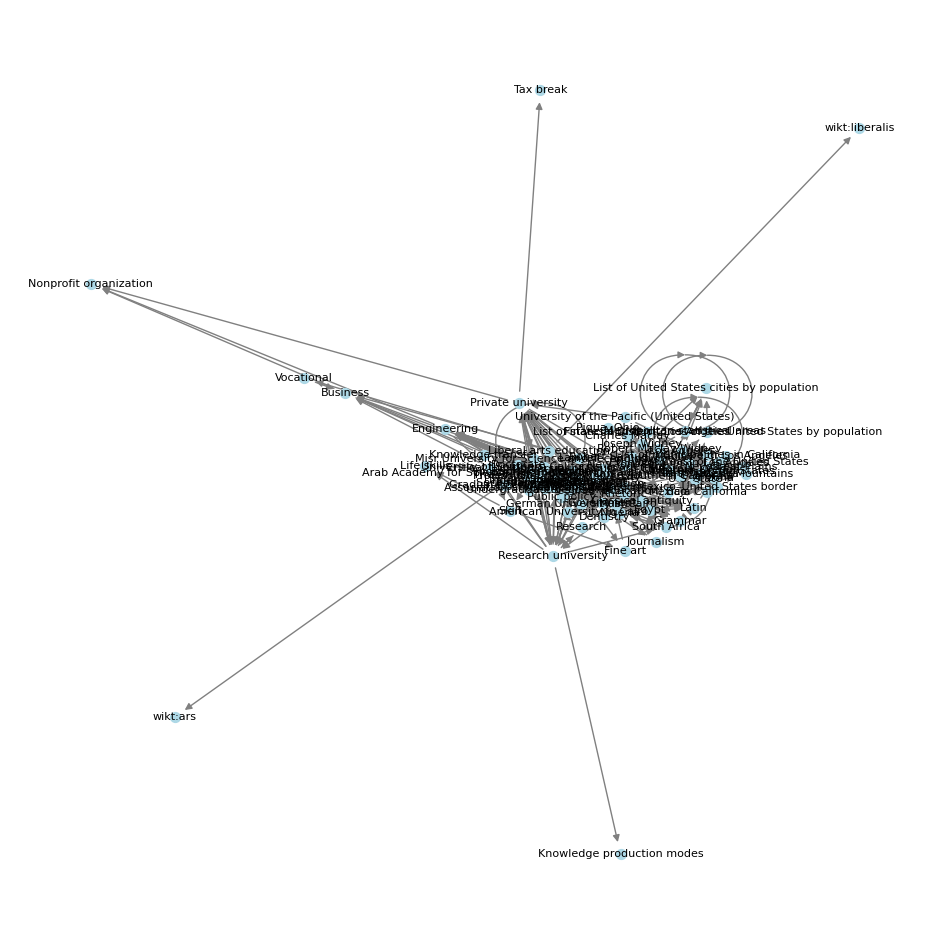

In [188]:
G = create_directed_graph(ten_outlink_from_usc_2_step)

plt.figure(figsize=(12, 12))  # Adjust figure size as needed

pos = nx.spring_layout(G)  # You can experiment with different layout algorithms

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="lightblue")

nx.draw_networkx_edges(G, pos, edge_color="gray")

# Draw labels (optional, might be cluttered for large graphs)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis("off")
plt.show()


plt.figure(figsize=(12, 12))  # Adjust figure size as needed

pos = nx.spring_layout(G)  # You can experiment with different layout algorithms

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="lightblue")

nx.draw_networkx_edges(G, pos, edge_color="gray")

# Draw labels (optional, might be cluttered for large graphs)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis("off")
plt.show()


# Get Revision History

In [49]:
def response_to_revisions(json_response):
    if type(json_response['query']['pages']) == dict:
        page_id = list(json_response['query']['pages'].keys())[0]
        return json_response['query']['pages'][page_id]['revisions']
    elif type(json_response['query']['pages']) == list:
        if 'revisions' in json_response['query']['pages'][0]:
            return json_response['query']['pages'][0]['revisions']
        else:
            return list()
    else:
        raise ValueError("There are no revisions in the JSON")


def get_all_page_revisions(page_title, endpoint='en.wikipedia.org/w/api.php', redirects=1):
    """Takes Wikipedia page title and returns a DataFrame of revisions

    page_title - a string with the title of the page on Wikipedia
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - a Boolean value for whether to follow redirects to another page

    Returns:
    df - a pandas DataFrame where each row is a revision and columns correspond
         to meta-data such as parentid, revid, sha1, size, timestamp, and user name
    """

    # A container to store all the revisions
    revision_list = list()

    # Set up the query
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'query'
    query_params['titles'] = page_title
    query_params['prop'] = 'revisions'
    query_params['rvprop'] = 'ids|userid|comment|timestamp|user|size|sha1'
    query_params['rvlimit'] = 500
    query_params['rvdir'] = 'newer'
    query_params['format'] = 'json'
    query_params['redirects'] = redirects
    query_params['formatversion'] = 2

    # Make the query
    json_response = requests.get(url = query_url, params = query_params).json()

    # Add the temporary list to the parent list
    revision_list += response_to_revisions(json_response)

    # Loop for the rest of the revisions
    while True:

        # Newer versions of the API return paginated results this way
        if 'continue' in json_response:
            query_continue_params = deepcopy(query_params)
            query_continue_params['rvcontinue'] = json_response['continue']['rvcontinue']
            json_response = requests.get(url = query_url, params = query_continue_params).json()
            revision_list += response_to_revisions(json_response)

        # Older versions of the API return paginated results this way
        elif 'query-continue' in json_response:
            query_continue_params = deepcopy(query_params)
            query_continue_params['rvstartid'] = json_response['query-continue']['revisions']['rvstartid']
            json_response = requests.get(url = query_url, params = query_continue_params).json()
            revision_list += response_to_revisions(json_response)

        # If there are no more revisions, stop
        else:
            break

    # Convert to a DataFrame
    df = pd.DataFrame(revision_list)

    # Add in some helpful fields to the DataFrame
    final_title = json_response['query']['pages'][0]['title']
    df['page'] = final_title
    df['userid'] = df['userid'].fillna(0).apply(lambda x:str(int(x)))
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].apply(lambda x:x.date())
    df['diff'] = df['size'].diff()
    df['lag'] = df['timestamp'].diff()/pd.Timedelta(1,'s')
    df['age'] = (df['timestamp'] - df['timestamp'].min())/pd.Timedelta(1,'d')

    return df


In [50]:
usc_df = get_all_page_revisions("University of Southern California")

In [51]:
usc_df

,revid,parentid,user,userid,timestamp,size,sha1,comment,anon,sha1hidden,suppressed,page,date,diff,lag,age
0,292249,0,Ulf Hermjakob,394971,2001-09-22 03:12:23+00:00,643,ae97f7b7d2515818e55f27cbc129a11e843e71e3,New entry for University of Southern California,NaN,NaN,NaN,University of Southern California,2001-09-22,NaN,NaN,0.000000
1,292250,292249,Ulf Hermjakob,394971,2001-09-22 07:43:41+00:00,606,bdf203c2b0282c57d5e17d97a9fa90ed6688f039,Moved link to USC.,NaN,NaN,NaN,University of Southern California,2001-09-22,-37.0,16278.0,0.188403
2,385135990,385123729,Larry Sanger,216,2001-09-22 08:18:31+00:00,595,432f88500387f83c17d8039e9c533dfc3f1d61a4,*,NaN,NaN,NaN,University of Southern California,2001-09-22,-11.0,2090.0,0.212593
3,97865,385135990,Conversion script,1226483,2002-02-25 15:51:15+00:00,609,69aac78ddd6112e492587090d6c0386b7ce43f44,Automated conversion,NaN,NaN,NaN,University of Southern California,2002-02-25,14.0,13505564.0,156.526991
4,97866,97865,Zoe,2376,2002-06-17 23:13:48+00:00,623,54593de11f80b5f67912bf83519dd5daacb7a211,*,NaN,NaN,NaN,University of Southern California,2002-06-17,14.0,9703353.0,268.834317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8838,1244953756,1244932962,LMilagros5472,36599126,2024-09-10 04:40:37+00:00,176957,329790eea3bb1981c0fa816f9a5f07003aa7ebd9,,NaN,NaN,NaN,University of Southern California,2024-09-10,6.0,11784.0,8389.061273
8839,1244953893,1244953756,LMilagros5472,36599126,2024-09-10 04:42:08+00:00,176962,84dfb82ea70b7619c278645eac8bf92e274c3f01,Highlight that most call it USC or SC,NaN,NaN,NaN,University of Southern California,2024-09-10,5.0,91.0,8389.062326
8840,1244983637,1244953893,ElKevbo,217538,2024-09-10 10:06:08+00:00,176951,8adc520fe79e88ff5b451fb86d487d9810b8f786,rv good faith edits - not an improvement,NaN,NaN,NaN,University of Southern California,2024-09-10,-11.0,19440.0,8389.287326
8841,1246118670,1244983637,68.181.17.172,0,2024-09-17 00:34:10+00:00,176950,c76f80d2a3993207fe112cfdc34b9205aea78760,,True,NaN,NaN,University of Southern California,2024-09-17,-1.0,570482.0,8395.890127


### User activity

We might be interested in looking at the most active editors over the history of the article. We can perform a `groupby` operation that effectively creates a mini-DataFrame for each user's revisions. We use the `aggregate` function to collection information (`len` gets us the number of revisions they made) across all these mini-DataFrames and returns a `Series` object with the username and the number of their revisions. Sorting these revisions is descending order and then look at the top-10 revisions.

In [13]:
usc_user = usc_df.groupby('user')
usc_user_revisions = usc_user['revid'].agg('count').sort_values(ascending=False)
print("There are {0} unique users who have made a contribution to the article.".format(len(usc_user_revisions)))
usc_user_revisions.head(10)

There are 3551 unique users who have made a contribution to the article.


,revid
user,
Bobak,510
Troyboysc,197
72.130.134.60,164
ElKevbo,148
Esrever,143
68.7.50.54,118
Wd40gdw,115
Contributor321,81
68.107.64.27,71


Given the wide variation among the number of contributions from users, we can create a kind of "histogram" that plots how many users made how many revisions. Because there is so much variation in the data, we use logged axes. In the upper left, there are several thousand editors who made only a single contribution. In the lower right, are the single editors listed above who made several hundred revisions to this article.

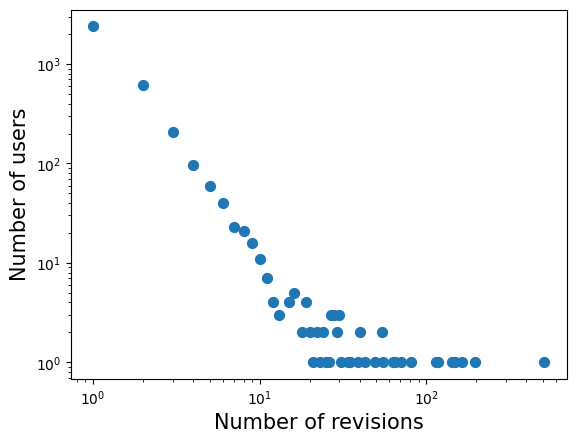

In [14]:
revisions_counter = Counter(usc_user_revisions.values)
plt.scatter(revisions_counter.keys(),revisions_counter.values(),s=50)
plt.ylabel('Number of users',fontsize=15)
plt.xlabel('Number of revisions',fontsize=15)
plt.yscale('log')
plt.xscale('log')

We'll add some information to the DataFrame about the cumulative number of unique users who've ever edited the article. This should give us a sense of how the size of the collaboration changed over time. Starting with empty lists for `unique_users` that we will add the names of users to as they make their first edit and `unique_count` that counts the number of unique users at each point in time. We add the `unique_count` list to the DataFrame under the `unique_users` column.

In [15]:
def count_unique_users(user_series):
    unique_users = []
    unique_count = []
    for user in user_series.values:
        if user not in unique_users:
            unique_users.append(user)
            unique_count.append(len(unique_users))
        else:
            unique_count.append(unique_count[-1])
    return unique_count

usc_df['unique_users'] = count_unique_users(usc_df['user'])

We can look at changes to the contribution patterns on the article over time. First we need to do some data processing to convert the timestamps into generic dates. Then we group the activity by date together and use aggregate to create a new DataFrame called `activity_by_day` that contains the number of unique users and number of revisions made on each day. Finally, plot the distribution of this activity over time. Peaks might correspond to major news events or to edit wars (editors fighting over content).

<ipython-input-16-0b3320d28fca>:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  activity_by_day = usc_df.groupby('date').aggregate({'unique_users':max,'revid':len})


Text(0.5, 0, 'Time')

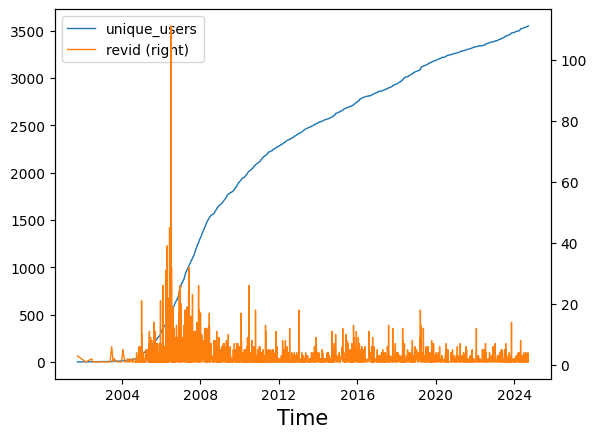

In [16]:
usc_df['date'] = usc_df['timestamp'].apply(lambda x:x.date())
activity_by_day = usc_df.groupby('date').aggregate({'unique_users':max,'revid':len})
ax = activity_by_day.plot(lw=1,secondary_y=['revid'])
ax.set_xlabel('Time',fontsize=15)

### Changes in article size

We can also look at the distribution in changes to the article's size. In other words, how much content (in bytes) was introduced or removed from the article by an editor's changes? We see there is a very wide (axes are still on log scales) and mostly symmetrical distribution in additions and removals of content. In other words, the most frequent changes are extremely minor (-1 to 1 bytes) and the biggest changes (dozens of kilobytes) are very rare --- and likely the result of vandalism and reversion of vandalism. Nevertheless it's the case that this Wikipedia article's history is as much about the *removal* of content as it is about the *addition* of content.

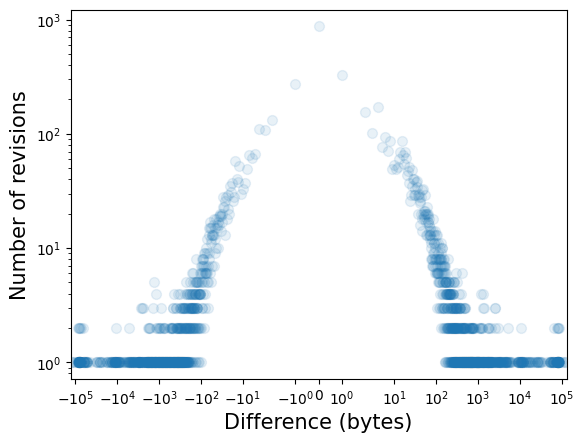

In [17]:
usc_df['diff'] = usc_df['size'].diff()
diff_counter = Counter(usc_df['diff'].values)
plt.scatter(diff_counter.keys(),diff_counter.values(),s=50,alpha=.1)
plt.xlabel('Difference (bytes)',fontsize=15)
plt.ylabel('Number of revisions',fontsize=15)
plt.yscale('log')
plt.xscale('symlog')

Re-compute the `activity_by_day` DataFrame to include the `diff` variable computed above using the `np.median` method to get the median change in the article on a given day. Substantively, this means that we can track how much content was added or removed on each day. This is noisy, so we can smooth using `rolling_mean` and specifying a 60-day window. There's a general tendency for the articl to grow on any given day, but there are a few time periods when the article shrinks drastically, likely reflecting sections of an article being [split out](https://en.wikipedia.org/wiki/Wikipedia:Splitting) into sub-articles.

<ipython-input-18-33a405842d56>:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  activity_by_day = usc_df.groupby('date').aggregate({'unique_users':max,
<ipython-input-18-33a405842d56>:1: FutureWarning: The provided callable <function median at 0x7f657754f9a0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  activity_by_day = usc_df.groupby('date').aggregate({'unique_users':max,
<ipython-input-18-33a405842d56>:10: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.axhline(0,lw=2,c='k')


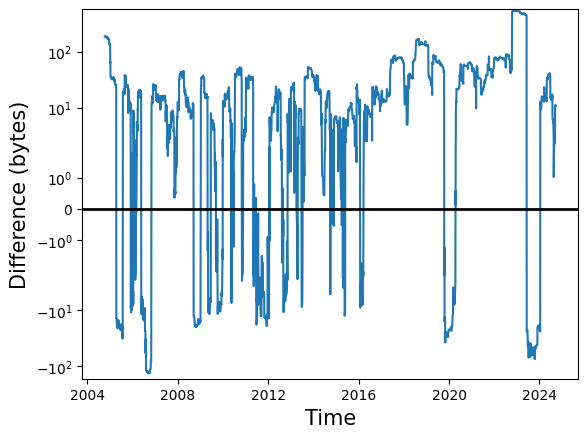

In [18]:
activity_by_day = usc_df.groupby('date').aggregate({'unique_users':max,
                                                       'revid':len,
                                                       'diff':np.median})

# Compute a 60-day rolling average to remove spikiness, plot
activity_by_day['diff'].rolling(60).mean().plot() # Use the rolling method with window 60
plt.yscale('symlog')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Difference (bytes)',fontsize=15)
plt.axhline(0,lw=2,c='k')

### Distribution of edit latencies

We can also explore how long an edit persists on the article before another edit is subsequently made.

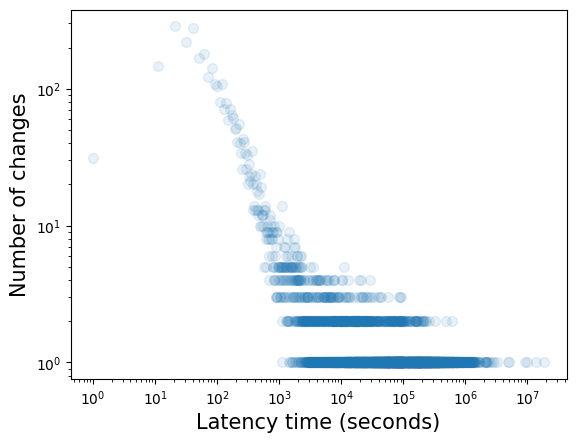

In [19]:
# The diff returns timedeltas, but dividing by a 1-second timedelta returns a float
# Round these numbers off to smooth out the distribution and add 1 second to everything to make the plot behave
usc_df['latency'] = [round(i/np.timedelta64(1,'s'),-1) + 1 for i in usc_df['timestamp'].diff().values]
diff_counter = Counter(usc_df['latency'].values)
plt.scatter(diff_counter.keys(),diff_counter.values(),s=50,alpha=.1)
plt.xlabel('Latency time (seconds)',fontsize=15)
plt.ylabel('Number of changes',fontsize=15)
plt.yscale('log')
plt.xscale('log')

In [20]:
usc_df['latency'].describe()

,latency
count,8.842000e+03
mean,8.206260e+04
std,3.419310e+05
min,1.000000e+00
25%,1.610000e+02
50%,4.771000e+03
75%,7.033600e+04
max,1.849165e+07


As we did above, we can recompute `activity_by_day` to include daily median changes in the latency between edits. There is substantial variation in how long edits persist.

<ipython-input-21-da21da7f7daa>:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  activity_by_day = usc_df.groupby('date').aggregate({'unique_users':max,
<ipython-input-21-da21da7f7daa>:1: FutureWarning: The provided callable <function median at 0x7f657754f9a0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  activity_by_day = usc_df.groupby('date').aggregate({'unique_users':max,


<Axes: xlabel='date'>

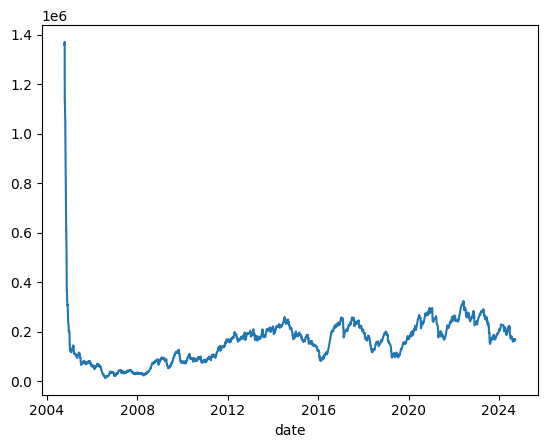

In [21]:
activity_by_day = usc_df.groupby('date').aggregate({'unique_users':max,
                                                       'revid':len,
                                                       'diff':np.median,
                                                       'latency':np.median})

# Compute a 60-day rolling average to remove spikiness, plot
activity_by_day['latency'].rolling(60).mean().plot() # Use the rolling method with window 60

### Co-authorship network

We previously created a direct network of hyperlinks where the nodes were all articles and the edges indicated the direction of the link(s) between the central article and its neighbors. In this section, we're going to construct a different kind of network that contains a mixture of editors and articles and the edges indicate whether an editor contributed to an article.

We go over every user in the `user` column inside `usc_df` and first check whether or not a (`user`,"University of Southern California") edge exists. If one already exists, then we increment its `weight` attribute by 1. Otherwise if there is no such edge in the network, we add a (`user`,"University of Southern California") edge with a `weight` of 1. We can inspect five of the edges to make sure this worked.

In [34]:

usc_bg = nx.Graph()
usc_bg.add_nodes_from(usc_df['user'].unique(), bipartite=0)
usc_bg.add_node("University of Southern California", bipartite=1)

for user in usc_df['user'].values:
    if usc_bg.has_edge(user, "University of Southern California"):
        usc_bg[user]["University of Southern California"]['weight'] += 1
    else:
        usc_bg.add_edge(user, "University of Southern California", weight=1)


print("There are {0} nodes and {1} edges in the network.".format(usc_bg.number_of_nodes(), usc_bg.number_of_edges()))

list(usc_bg.edges(data=True))[:5]

There are 3552 nodes and 3551 edges in the network.


[('Ulf Hermjakob', 'University of Southern California', {'weight': 2}),
 ('Larry Sanger', 'University of Southern California', {'weight': 1}),
 ('Conversion script', 'University of Southern California', {'weight': 1}),
 ('Zoe', 'University of Southern California', {'weight': 3}),
 ('KF', 'University of Southern California', {'weight': 3})]

# Co-authorship network of the hyperlink neighborhood

Based on everything we did in the previous analysis to query the revisions, reshape and clean up the data, and extract new features for analysis, we are now going to write a big function that does all of this automatically. The function `get_revision_df` will accept an article name, perform the query, and proceed to do many of the steps outlined above, and returns a cleaned DataFrame at the end.

In [52]:
import requests
import pandas as pd
import numpy as np

def wikipedia_query(params, endpoint='https://en.wikipedia.org/w/api.php'):
    """Helper function to query the Wikipedia API with pagination support."""
    all_data = []
    while True:
        response = requests.get(endpoint, params=params).json()
        if 'query' in response:
            for page in response['query']['pages'].values():
                if 'revisions' in page:
                    all_data.extend(page['revisions'])

        # Check for continuation
        if 'continue' in response:
            for key, value in response['continue'].items():
                params[key] = value
        else:
            break

    return all_data

def get_revision_df(article):
    revisions_query = {
        'action': 'query',
        'redirects': 1,
        'prop': 'revisions',
        'titles': article,
        'rvprop': 'ids|user|timestamp|userid|comment|size',
        'rvlimit': 500,
        'rvdir': 'newer',
        'format': 'json'
    }

    revisions_data = wikipedia_query(revisions_query)

    # Extract and convert to DataFrame. Handle pages that don't exist
    if not revisions_data:
        print(f"{article} doesn't exist or has no revisions!")
        return pd.DataFrame()

    df = pd.DataFrame(revisions_data)

    # Make it clear what's being edited
    df['page'] = article

    # Clean up timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%dT%H:%M:%SZ")

    # Clean up anon column. Handle articles with all non-anon editors
    if 'anon' in df.columns:
        df['anon'] = df['anon'].notnull()
    else:
        df['anon'] = False

    # Sort the data on timestamp and reset the index
    df.sort_values('timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Set the index to a MultiIndex
    df.index.name = 'revision'

    # Compute additional features
    df['date'] = df['timestamp'].dt.date
    df['diff'] = df['size'].diff()
    df['unique_users'] = len(set(df['user']))

    # Calculate latency in seconds and round it
    df['latency'] = df['timestamp'].diff().dt.total_seconds().fillna(0).round(-1) + 1

    # Select relevant columns to return
    df = df[['anon', 'comment', 'revid', 'size', 'timestamp',
             'user', 'userid', 'unique_users', 'date', 'diff', 'latency']]

    return df

           anon                                          comment       revid  \
revision                                                                       
0         False  New entry for University of Southern California      292249   
1         False                               Moved link to USC.      292250   
2         False                                                *   385135990   
3         False                             Automated conversion       97865   
4         False                                                *       97866   
...         ...                                              ...         ...   
8838      False                                                   1244953756   
8839      False            Highlight that most call it USC or SC  1244953893   
8840      False         rv good faith edits - not an improvement  1244983637   
8841       True                                                   1246118670   
8842      False                         

In [53]:
usc_revisions_df = get_revision_df("University of Southern California")
usc_revisions_df

,anon,comment,revid,size,timestamp,user,userid,unique_users,date,diff,latency
revision,,,,,,,,,,,
0,False,New entry for University of Southern California,292249,643,2001-09-22 03:12:23,Ulf Hermjakob,394971,3551,2001-09-22,NaN,1.0
1,False,Moved link to USC.,292250,606,2001-09-22 07:43:41,Ulf Hermjakob,394971,3551,2001-09-22,-37.0,16281.0
2,False,*,385135990,595,2001-09-22 08:18:31,Larry Sanger,216,3551,2001-09-22,-11.0,2091.0
3,False,Automated conversion,97865,609,2002-02-25 15:51:15,Conversion script,1226483,3551,2002-02-25,14.0,13505561.0
4,False,*,97866,623,2002-06-17 23:13:48,Zoe,2376,3551,2002-06-17,14.0,9703351.0
...,...,...,...,...,...,...,...,...,...,...,...
8838,False,,1244953756,176957,2024-09-10 04:40:37,LMilagros5472,36599126,3551,2024-09-10,6.0,11781.0
8839,False,Highlight that most call it USC or SC,1244953893,176962,2024-09-10 04:42:08,LMilagros5472,36599126,3551,2024-09-10,5.0,91.0
8840,False,rv good faith edits - not an improvement,1244983637,176951,2024-09-10 10:06:08,ElKevbo,217538,3551,2024-09-10,-11.0,19441.0


In [54]:
ucla_revisions_df = get_revision_df("University of California, Los Angeles")
ucla_revisions_df

,anon,comment,revid,size,timestamp,user,userid,unique_users,date,diff,latency
revision,,,,,,,,,,,
0,False,short new entry,10869,256,2002-02-14 14:39:04,Jeronimo,108.0,3681,2002-02-14,NaN,1.0
1,True,external link section,10886,293,2002-02-14 15:05:49,195.249.25.202,0.0,3681,2002-02-14,37.0,1601.0
2,False,Rivalry with USC,62099,451,2002-02-25 15:51:15,Brooke Vibber,51.0,3681,2002-02-25,158.0,953131.0
3,False,+location; lang link: eo,97861,594,2002-05-04 04:13:54,Brooke Vibber,51.0,3681,2002-05-04,143.0,5833361.0
4,False,*,111581,618,2002-06-17 23:12:44,Zoe,2376.0,3681,2002-06-17,24.0,3869931.0
...,...,...,...,...,...,...,...,...,...,...,...
9982,False,/* Student life */ [[WP:EL]],1246004223,182775,2024-09-16 10:36:11,ElKevbo,217538.0,3681,2024-09-16,-29.0,41.0
9983,True,"Not sure if improvement, seems like it should ...",1246128412,182775,2024-09-17 01:52:38,76.88.55.135,0.0,3681,2024-09-17,0.0,54991.0
9984,True,,1246151681,182527,2024-09-17 06:29:43,135.180.71.238,0.0,3681,2024-09-17,-248.0,16621.0


We've created a DataFrame for both USC and UCLA revision history. We can now combine both of these together using the `concat` method. We can check to make sure that they both made it into the dataframe by checking the first level of the `index` and we see they're both there.

In [55]:
rivalry_df = pd.concat([usc_revisions_df,ucla_revisions_df])

print("There are a total of {0} revisions across both the USC and UCLA articles.".format(len(rivalry_df)))

There are a total of 18830 revisions across both the USC and UCLA articles.


In [63]:
rivalry_df = pd.concat([usc_revisions_df, ucla_revisions_df], keys=['University of Southern California', 'University of California, Los Angeles'])
rivalry_df = rivalry_df.reset_index(level=0)
rivalry_df = rivalry_df.rename(columns={'level_0': 'page'})
print("There are a total of {0} revisions across both the USC and UCLA articles.".format(len(rivalry_df)))
rivalry_df

There are a total of 18830 revisions across both the USC and UCLA articles.


,page,anon,comment,revid,size,timestamp,user,userid,unique_users,date,diff,latency
revision,,,,,,,,,,,,
0,University of Southern California,False,New entry for University of Southern California,292249,643,2001-09-22 03:12:23,Ulf Hermjakob,394971.0,3551,2001-09-22,NaN,1.0
1,University of Southern California,False,Moved link to USC.,292250,606,2001-09-22 07:43:41,Ulf Hermjakob,394971.0,3551,2001-09-22,-37.0,16281.0
2,University of Southern California,False,*,385135990,595,2001-09-22 08:18:31,Larry Sanger,216.0,3551,2001-09-22,-11.0,2091.0
3,University of Southern California,False,Automated conversion,97865,609,2002-02-25 15:51:15,Conversion script,1226483.0,3551,2002-02-25,14.0,13505561.0
4,University of Southern California,False,*,97866,623,2002-06-17 23:13:48,Zoe,2376.0,3551,2002-06-17,14.0,9703351.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9982,"University of California, Los Angeles",False,/* Student life */ [[WP:EL]],1246004223,182775,2024-09-16 10:36:11,ElKevbo,217538.0,3681,2024-09-16,-29.0,41.0
9983,"University of California, Los Angeles",True,"Not sure if improvement, seems like it should ...",1246128412,182775,2024-09-17 01:52:38,76.88.55.135,0.0,3681,2024-09-17,0.0,54991.0
9984,"University of California, Los Angeles",True,,1246151681,182527,2024-09-17 06:29:43,135.180.71.238,0.0,3681,2024-09-17,-248.0,16621.0


We want to create an "edgelist" that contains all the (`editor`, `article`) pairs of who contributed to which articles. This could by done by looping over the list, but this is inefficient on larger datasets like the one we crawled. Instead, we'll use a `groupby` approach to not only count the number of times an editor contributed to an article (the `weight` we defined previous), but a whole host of other potentially interesting attributes.

We use the `agg` method on the data that's been grouped by `page` and `user` to aggregate the information into nice summary statistics. We count the number of revisions using `len` and relabel this variable `weight`. For the `timestamp`, `diff`, `latency`, and `revision` variables, we compute new summary statistics for the minimum, median, and maximum values. This operation returns a new DataFrame, indexed by (`page`, `user`) with columns corresponding to labels like `weight`, `ts_min`, etc. Each row in this DataFrame will become attributes in the graph object we make below. This operation creates a weird multi-column, so we drop the redundant 0-level of the column to have a nice concise column.

We're going to do something different to the `timestamp` data because these data are stored as `Timestamp` objects that don't always place nicely with other functions. Instead, we're going to convert these data to counts for the amount of time (in days) since January 16, 2001, the date that Wikipedia was founded. In effect, we're counting how "old" Wikipedia was when an action occurred and this `float` count will work better in subsequent steps.

In [66]:
# Group by 'page' and 'user'
rivalry_gb_edge = rivalry_df.reset_index().groupby(['page', 'user'])

# Aggregate the data to create an edge list
rivalry_edgelist = rivalry_gb_edge.agg(
    weight=('revid', len),  # Calculate weight as the length of 'revid'
    ts_min=('timestamp', np.min),  # Calculate minimum timestamp
    ts_max=('timestamp', np.max),  # Calculate maximum timestamp
    diff_min=('diff', np.min),  # Calculate minimum diff
    diff_median=('diff', np.median),  # Calculate median diff
    diff_max=('diff', np.max),  # Calculate maximum diff
    latency_min=('latency', np.min),  # Calculate minimum latency
    latency_median=('latency', np.median),  # Calculate median latency
    latency_max=('latency', np.max),  # Calculate maximum latency
    revision_min=('revision', np.min),  # Calculate minimum revision
    revision_max=('revision', np.max)  # Calculate maximum revision
)

# Convert the ts_min and ts_max to floats for the number of days since Wikipedia was founded
rivalry_edgelist['ts_min'] = (rivalry_edgelist['ts_min'] - pd.Timestamp('2001-1-16')) / np.timedelta64(1, 'D')
rivalry_edgelist['ts_max'] = (rivalry_edgelist['ts_max'] - pd.Timestamp('2001-1-16')) / np.timedelta64(1, 'D')

# Display the head of the edge list DataFrame
rivalry_edgelist.head()

<ipython-input-66-4070b9739ee0>:5: FutureWarning: The provided callable <function min at 0x7f657a10fac0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  rivalry_edgelist = rivalry_gb_edge.agg(
<ipython-input-66-4070b9739ee0>:5: FutureWarning: The provided callable <function max at 0x7f657a10f9a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  rivalry_edgelist = rivalry_gb_edge.agg(
<ipython-input-66-4070b9739ee0>:5: FutureWarning: The provided callable <function median at 0x7f657754f9a0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  rivalry_edgelist = rivalry_gb_edge.agg(


weight  \
page                                  user                                                         
University of California, Los Angeles 00johnny cage123                                         2   
                                      0CD is U                                                 1   
                                      0CD nutty editors                                        1   
                                      0CD therapist                                            1   
                                      0bsessive c0mpulsive dis0rder & wikipeedia ADDI...       1   

                                                                                               ts_min  \
page                                  user                                                              
University of California, Los Angeles 00johnny cage123                                    6339.452118   
                                      0CD is U                                            2308.167697   
                                      0CD nutty editors                                   2307.880926   
                                      0CD therapist                                       2307.106030   
                                      0bsessive c0mpulsive dis0rder & wikipeedia ADDI...  2308.417859   

                                                                                               ts_max  \
page                                  user                                                              
University of California, Los Angeles 00johnny cage123                                    6339.465289   
                                      0CD is U                                            2308.167697   
                                      0CD nutty editors                                   2307.880926   
                                      0CD therapist                                       2307.106030   
                                      0bsessive c0mpulsive dis0rder & wikipeedia ADDI...  2308.417859   

                                                                                          diff_min  \
page                                  user                                                           
University of California, Los Angeles 00johnny cage123                                        72.0   
                                      0CD is U                                                48.0   
                                      0CD nutty editors                                       48.0   
                                      0CD therapist                                           47.0   
                                      0bsessive c0mpulsive dis0rder & wikipeedia ADDI...      48.0   

                                                                                          diff_median  \
page                                  user                                                              
University of California, Los Angeles 00johnny cage123                                          199.0   
                                      0CD is U                                                   48.0   
                                      0CD nutty editors                                          48.0   
                                      0CD therapist                                              47.0   
                                      0bsessive c0mpulsive dis0rder & wikipeedia ADDI...         48.0   

                                                                                          diff_max  \
page                                  user                                                           
University of California, Los Angeles 00johnny cage123                                       326.0   
                                      0CD is U                                                48.0   
                                      0CD nutty editors   

The nodes in this bipartite network also have attributes we can extract from the data. Remember, because this is a bipartite network, we'll need to generate attribute data for both the users and the pages. We can perform an analogous `groupby` operation as we used above, but simply group on either the `user` or the `page` values. After each of these `groupby` operations, we can perform similar `agg` operations to aggregate the data into summary statistics. In the case of the user, these summary statistics are across all articles in the data. Thus the `rivalry_usernodelist` summarizes how many total edits a *user* made, their first and last observed edits, and the distribution of their `diff`, `latency`, and `revision` statistics. The `rivalry_pagenodelist` summarizes how many total edits were made to the *page*, the date of the first and last edit, and so on.

In [68]:
# Create the user node list by grouping on user and aggregating
rivalry_gb_user = rivalry_df.reset_index().groupby(['user'])
rivalry_usernodelist = rivalry_gb_user.agg(
    revisions=('revid', len),
    ts_min=('timestamp', np.min),
    ts_max=('timestamp', np.max),
    diff_min=('diff', np.min),
    diff_median=('diff', np.median),
    diff_max=('diff', np.max),
    latency_min=('latency', np.min),
    latency_median=('latency', np.median),
    latency_max=('latency', np.max),
    revision_min=('revision', np.min),
    revision_median=('revision', np.median),
    revision_max=('revision', np.max)
)

# Convert the timestamps to counts
rivalry_usernodelist['ts_min'] = (rivalry_usernodelist['ts_min'] - pd.Timestamp('2001-1-16')) / np.timedelta64(1, 'D')
rivalry_usernodelist['ts_max'] = (rivalry_usernodelist['ts_max'] - pd.Timestamp('2001-1-16')) / np.timedelta64(1, 'D')

# Create the page node list by grouping on page and aggregating
rivalry_gb_page = rivalry_df.reset_index().groupby(['page'])
rivalry_pagenodelist = rivalry_gb_page.agg(
    revisions=('revid', len),
    ts_min=('timestamp', np.min),
    ts_max=('timestamp', np.max),
    diff_min=('diff', np.min),
    diff_median=('diff', np.median),
    diff_max=('diff', np.max),
    latency_min=('latency', np.min),
    latency_median=('latency', np.median),
    latency_max=('latency', np.max),
    revision_min=('revision', np.min),
    revision_median=('revision', np.median),
    revision_max=('revision', np.max)
)

# Convert the timestamps to counts
rivalry_pagenodelist['ts_min'] = (rivalry_pagenodelist['ts_min'] - pd.Timestamp('2001-1-16')) / np.timedelta64(1, 'D')
rivalry_pagenodelist['ts_max'] = (rivalry_pagenodelist['ts_max'] - pd.Timestamp('2001-1-16')) / np.timedelta64(1, 'D')

# Display the head of the page node list DataFrame
rivalry_pagenodelist.head()

<ipython-input-68-815d2db6dfe1>:3: FutureWarning: The provided callable <function min at 0x7f657a10fac0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  rivalry_usernodelist = rivalry_gb_user.agg(
<ipython-input-68-815d2db6dfe1>:3: FutureWarning: The provided callable <function max at 0x7f657a10f9a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  rivalry_usernodelist = rivalry_gb_user.agg(
<ipython-input-68-815d2db6dfe1>:3: FutureWarning: The provided callable <function median at 0x7f657754f9a0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  rivalry_usernodelist = rivalry_gb_user.agg(
<ipython-input-68-815d2db6df

,revisions,ts_min,ts_max,diff_min,diff_median,diff_max,latency_min,latency_median,latency_max,revision_min,revision_median,revision_max
page,,,,,,,,,,,,
"University of California, Los Angeles",9987,394.610463,8646.617778,-502832.0,1.0,502832.0,1.0,3191.0,18952441.0,0,4993.0,9986
University of Southern California,8843,249.133600,8647.148843,-118458.0,2.0,118458.0,1.0,4761.0,18491651.0,0,4421.0,8842


Now that we've created all this rich contextual data about edges, pages, and editors, we can load it all into a `NetworkX` `DiGraph` object called `rivalry_g`. We start by looping over the index in the `rivalry_edgelist` dataframe that corresponds to the edges in the network, convert the edge attributes to a dictionary for `NetworkX` to better digest, and then add this edge and all its data to the `rivalry_g` graph object. This creates placeholder nodes, but we want to add the rich node data we created above as well. We can loop over the `rivalry_usernodelist`, convert the node attributes to a dictionary, and then overwrite the placeholder nodes by adding the data-rich user nodes to the `rivalry_g` graph object. We do the same for the `rivalry_pagenodelist`, then check the number of nodes and edges in the network, and finally print out a few examples of the data-rich nodes and edges.

In [119]:
# Initialize a bipartite graph
rivalry_g = nx.Graph()

# Define node sets
editors = set(rivalry_edgelist.index.get_level_values(1))
articles = set(rivalry_edgelist.index.get_level_values(0))

# Add the edges and edge attributes
for (article, editor) in iter(rivalry_edgelist.index.values):
    edge_attributes = dict(rivalry_edgelist.loc[(article, editor)])
    rivalry_g.add_edge(editor, article, **edge_attributes)

# Add the user nodes and attributes
for node in iter(rivalry_usernodelist.index):
    node_attributes = dict(rivalry_usernodelist.loc[node])
    rivalry_g.add_node(node, **node_attributes)

# Add the page nodes and attributes
for node in iter(rivalry_pagenodelist.index):
    node_attributes = dict(rivalry_pagenodelist.loc[node])
    rivalry_g.add_node(node, **node_attributes)

# Assign node sets for bipartite structure
nx.set_node_attributes(rivalry_g, {node: 0 for node in editors}, 'bipartite')
nx.set_node_attributes(rivalry_g, {node: 1 for node in articles}, 'bipartite')

print("There are {0} nodes and {1} edges in the network.".format(rivalry_g.number_of_nodes(), rivalry_g.number_of_edges()))

# Display a sample of edges with their data
print(list(rivalry_g.edges(data=True))[:3])

There are 6760 nodes and 7231 edges in the network.
[('00johnny cage123', 'University of California, Los Angeles', {'weight': 2.0, 'ts_min': 6339.452118055556, 'ts_max': 6339.465289351851, 'diff_min': 72.0, 'diff_median': 199.0, 'diff_max': 326.0, 'latency_min': 1141.0, 'latency_median': 99046.0, 'latency_max': 196951.0, 'revision_min': 8659.0, 'revision_max': 8660.0}), ('University of California, Los Angeles', '0CD is U', {'weight': 1.0, 'ts_min': 2308.1676967592593, 'ts_max': 2308.1676967592593, 'diff_min': 48.0, 'diff_median': 48.0, 'diff_max': 48.0, 'latency_min': 23101.0, 'latency_median': 23101.0, 'latency_max': 23101.0, 'revision_min': 3035.0, 'revision_max': 3035.0}), ('University of California, Los Angeles', '0CD nutty editors', {'weight': 1.0, 'ts_min': 2307.880925925926, 'ts_max': 2307.880925925926, 'diff_min': 48.0, 'diff_median': 48.0, 'diff_max': 48.0, 'latency_min': 40551.0, 'latency_median': 40551.0, 'latency_max': 40551.0, 'revision_min': 3033.0, 'revision_max': 3033.0

### Scrape revisions for all the articles in the hyperlink network

In [120]:
# List of DataFrames
dataframe_dict = {}

# Start the scrape
errors = list()
for article in tqdm(ten_outlink_from_usc):
    try:
        df = get_revision_df(article)
        dataframe_dict[article] = df
    except:
        errors.append(article)
        pass

gigantic_df = pd.concat(dataframe_dict.values(), keys=ten_outlink_from_usc)

100%|██████████| 11/11 [00:40<00:00,  3.67s/it]


In [121]:
gigantic_df = gigantic_df.reset_index(level=0)
gigantic_df = gigantic_df.rename(columns={'level_0': 'page'})
gigantic_df

,page,anon,comment,revid,size,timestamp,user,userid,unique_users,date,diff,latency
revision,,,,,,,,,,,,
0,Private university,False,,11946279,630,2005-04-06 06:23:40,BD2412,196446,1171,2005-04-06,NaN,1.0
1,Private university,False,,11946301,630,2005-04-06 06:23:54,BD2412,196446,1171,2005-04-06,0.0,11.0
2,Private university,False,,11946305,631,2005-04-06 06:24:50,BD2412,196446,1171,2005-04-06,1.0,61.0
3,Private university,False,,11946322,632,2005-04-06 06:25:01,BD2412,196446,1171,2005-04-06,1.0,11.0
4,Private university,False,,11946345,628,2005-04-06 06:25:42,BD2412,196446,1171,2005-04-06,-4.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8838,University of Southern California,False,,1244953756,176957,2024-09-10 04:40:37,LMilagros5472,36599126,3551,2024-09-10,6.0,11781.0
8839,University of Southern California,False,Highlight that most call it USC or SC,1244953893,176962,2024-09-10 04:42:08,LMilagros5472,36599126,3551,2024-09-10,5.0,91.0
8840,University of Southern California,False,rv good faith edits - not an improvement,1244983637,176951,2024-09-10 10:06:08,ElKevbo,217538,3551,2024-09-10,-11.0,19441.0


### Make a coauthorship network

The analysis can start again here by loading the CSV file rather than having to re-scrape the data from above. Loading the file to `gigantic_df`, there are a few rows that seem to be broken, so we'll use `drop` to remove them. We also use `to_datetime` to make sure the timestamp information is using the appropriate units.

In [122]:
gigantic_df['timestamp'] = pd.to_datetime(gigantic_df['timestamp'],unit='s')
gigantic_df['date'] = pd.to_datetime(gigantic_df['date'])

gigantic_df.head()

,page,anon,comment,revid,size,timestamp,user,userid,unique_users,date,diff,latency
revision,,,,,,,,,,,,
0,Private university,False,,11946279,630,2005-04-06 06:23:40,BD2412,196446,1171,2005-04-06,NaN,1.0
1,Private university,False,,11946301,630,2005-04-06 06:23:54,BD2412,196446,1171,2005-04-06,0.0,11.0
2,Private university,False,,11946305,631,2005-04-06 06:24:50,BD2412,196446,1171,2005-04-06,1.0,61.0
3,Private university,False,,11946322,632,2005-04-06 06:25:01,BD2412,196446,1171,2005-04-06,1.0,11.0
4,Private university,False,,11946345,628,2005-04-06 06:25:42,BD2412,196446,1171,2005-04-06,-4.0,41.0


Now do all the `groupby` and `agg` operations to create the edgelists and nodelists we'll need to make a network as well as the data cleanup steps we did above.

In [124]:
edge_agg_function = {'revid':len,
                     'timestamp':[np.min, np.max],
                     'diff':[np.min,np.median, np.max],
                     'latency':[np.min, np.median, np.max],
                     'revision':[np.min, np.max]
                     }

# Create the edgelist by grouping on both page and user
gigantic_gb_edge = gigantic_df.reset_index().groupby(['page','user'])
gigantic_edgelist = gigantic_gb_edge.agg(edge_agg_function)

# Rename the columns
gigantic_edgelist.columns = ['weight','ts_min','ts_max','diff_min','diff_median',
                            'diff_max','latency_min','latency_median','latency_max','revision_min','revision_max']

# Convert the ts_min and ts_max to floats for the number of days since Wikipedia was founded
gigantic_edgelist['ts_min'] = (gigantic_edgelist['ts_min'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')
gigantic_edgelist['ts_max'] = (gigantic_edgelist['ts_max'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')

print("There are {0} edges in the network.".format(len(gigantic_edgelist)))

There are 18441 edges in the network.


<ipython-input-124-01a9e712549d>:10: FutureWarning: The provided callable <function min at 0x7f657a10fac0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  gigantic_edgelist = gigantic_gb_edge.agg(edge_agg_function)
<ipython-input-124-01a9e712549d>:10: FutureWarning: The provided callable <function max at 0x7f657a10f9a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  gigantic_edgelist = gigantic_gb_edge.agg(edge_agg_function)
<ipython-input-124-01a9e712549d>:10: FutureWarning: The provided callable <function median at 0x7f657754f9a0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  gigantic_edgelist = gigantic_gb_ed

In [125]:
edge_agg_function = {'revid':len,
                     'timestamp':[np.min,np.max],
                     'diff':[np.min,np.median,np.max],
                     'latency':[np.min,np.median,np.max],
                     'revision':[np.min,np.max]
                     }

# Create the edgelist by grouping on both page and user
gigantic_gb_edge = gigantic_df.reset_index().groupby(['page','user'])
gigantic_edgelist = gigantic_gb_edge.agg(edge_agg_function)

# Rename columns
gigantic_edgelist.columns = ['weight','ts_min','ts_max','diff_min','diff_median','diff_max','latency_min',
                         'latency_median','latency_max','revision_min','revision_max']

# Convert the ts_min and ts_max to floats for the number of days since Wikipedia was founded
gigantic_edgelist['ts_min'] = (gigantic_edgelist['ts_min'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')
gigantic_edgelist['ts_max'] = (gigantic_edgelist['ts_max'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')

print("There are {0} edges in the network.".format(len(gigantic_edgelist)))

There are 18441 edges in the network.


<ipython-input-125-a6525bfb10cb>:10: FutureWarning: The provided callable <function min at 0x7f657a10fac0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  gigantic_edgelist = gigantic_gb_edge.agg(edge_agg_function)
<ipython-input-125-a6525bfb10cb>:10: FutureWarning: The provided callable <function max at 0x7f657a10f9a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  gigantic_edgelist = gigantic_gb_edge.agg(edge_agg_function)
<ipython-input-125-a6525bfb10cb>:10: FutureWarning: The provided callable <function median at 0x7f657754f9a0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  gigantic_edgelist = gigantic_gb_ed

In [126]:
# Create the usernodelist by grouping on page and aggregating
gigantic_gb_page = gigantic_df.reset_index().groupby(['page'])

# Define node_agg_function
node_agg_function = {'revid':[len], # Changed to a list of functions
                     'timestamp':[np.min,np.max],
                     'diff':[np.min,np.median,np.max],
                     'latency':[np.min,np.median,np.max],
                     'revision':[np.min,np.max]
                     }

gigantic_pagenodelist = gigantic_gb_page.agg(node_agg_function)

# Clean up the columns and convert the timestamps to counts
# Rename columns after aggregation
gigantic_pagenodelist.columns = ['weight','ts_min','ts_max','diff_min','diff_median','diff_max','latency_min',
                         'latency_median','latency_max','revision_min','revision_max'] # Added this line to rename columns

gigantic_pagenodelist['ts_min'] = (gigantic_pagenodelist['ts_min'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')
gigantic_pagenodelist['ts_max'] = (gigantic_pagenodelist['ts_max'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')

print("There are {0} page nodes in the network.".format(len(gigantic_pagenodelist)))

gigantic_pagenodelist

<ipython-input-126-53e3df6b9442>:12: FutureWarning: The provided callable <function min at 0x7f657a10fac0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  gigantic_pagenodelist = gigantic_gb_page.agg(node_agg_function)
<ipython-input-126-53e3df6b9442>:12: FutureWarning: The provided callable <function max at 0x7f657a10f9a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  gigantic_pagenodelist = gigantic_gb_page.agg(node_agg_function)
<ipython-input-126-53e3df6b9442>:12: FutureWarning: The provided callable <function median at 0x7f657754f9a0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  gigantic_pagenodelist = gi

There are 11 page nodes in the network.


,weight,ts_min,ts_max,diff_min,diff_median,diff_max,latency_min,latency_median,latency_max,revision_min,revision_max
page,,,,,,,,,,,
California,12617,305.902037,8647.225590,-1947126.0,3.0,1947126.0,1.0,4331.0,5530891.0,0,12616
Graduate school,926,686.023796,8603.354375,-40732.0,3.0,40732.0,1.0,202831.0,12648781.0,0,925
Liberal arts education,1548,360.117060,8644.217859,-83757.0,4.0,83757.0,1.0,96531.0,32003031.0,0,1547
Los Angeles,15254,270.930891,8646.479433,-330258.0,2.0,330258.0,1.0,4101.0,10523821.0,0,15253
Postgraduate education,926,686.023796,8603.354375,-40732.0,3.0,40732.0,1.0,202831.0,12648781.0,0,925
Private university,2414,1541.266435,8637.484734,-54185.0,6.0,54185.0,1.0,26946.0,5791871.0,0,2413
Research university,359,1393.507616,8646.830243,-7345.0,4.0,7736.0,1.0,36041.0,137746161.0,0,358
Robert Maclay Widney,68,2000.324375,8338.640370,-292.0,1.0,1064.0,1.0,1817236.0,58088361.0,0,67
Undergraduate education,948,831.345093,8638.039780,-22573.0,4.0,21463.0,1.0,106056.0,13900921.0,0,947


Having created the edge and node lists in the previous step, we can now add these data to a `NetworkX` `DiGraph` object we'll call `gigantic_g`. As before, we add the edges and edge attributes from `gigantic_edgelist` and then add the nodes and node attribtues from `gigantic_usernodelist` and `gigantic_pagenodelist`. We perform a dictionary comprehension to convert the values of the attribtues in the dictionary to `float` data type rather than the `numpy.float64` which doesn't play nicely with the graph writing function in `NetworkX`. And then we can do the "grand reveal" to describe the coauthorship network of the articles in the hyperlink network neighborhood of USC article.

In [128]:
# Create the usernodelist by grouping on user and aggregating
gigantic_gb_user = gigantic_df.reset_index().groupby(['user'])

# Define node_agg_function
node_agg_function = {'revid':[len], # Changed to a list of functions
                     'timestamp':[np.min,np.max],
                     'diff':[np.min,np.median,np.max],
                     'latency':[np.min,np.median,np.max],
                     'revision':[np.min,np.max]
                     }

gigantic_usernodelist = gigantic_gb_user.agg(node_agg_function)

# Clean up the columns and convert the timestamps to counts
# Rename columns after aggregation
gigantic_usernodelist.columns = ['weight','ts_min','ts_max','diff_min','diff_median','diff_max','latency_min',
                         'latency_median','latency_max','revision_min','revision_max'] # Added this line to rename columns

gigantic_usernodelist['ts_min'] = (gigantic_usernodelist['ts_min'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')
gigantic_usernodelist['ts_max'] = (gigantic_usernodelist['ts_max'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')

print("There are {0} user nodes in the network.".format(len(gigantic_usernodelist)))

There are 15999 user nodes in the network.


<ipython-input-128-028c113ba1bd>:12: FutureWarning: The provided callable <function min at 0x7f657a10fac0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  gigantic_usernodelist = gigantic_gb_user.agg(node_agg_function)
<ipython-input-128-028c113ba1bd>:12: FutureWarning: The provided callable <function max at 0x7f657a10f9a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  gigantic_usernodelist = gigantic_gb_user.agg(node_agg_function)
<ipython-input-128-028c113ba1bd>:12: FutureWarning: The provided callable <function median at 0x7f657754f9a0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  gigantic_usernodelist = gi

In [129]:
# Initialize a bipartite graph
gigantic_g = nx.Graph()

# Define node sets
editors = set(gigantic_edgelist.index.get_level_values(1))
articles = set(gigantic_edgelist.index.get_level_values(0))

# Add the edges and edge attributes
for (article, editor) in iter(gigantic_edgelist.index.values):
    edge_attributes = dict(gigantic_edgelist.loc[(article, editor)])
    edge_attributes = {k: float(v) for k, v in edge_attributes.items()}
    gigantic_g.add_edge(editor, article, **edge_attributes)

# Add the user nodes and attributes
for node in iter(gigantic_usernodelist.index):
    node_attributes = dict(gigantic_usernodelist.loc[node])
    node_attributes = {k: float(v) for k, v in node_attributes.items()}
    gigantic_g.add_node(node, **node_attributes)

# Add the page nodes and attributes
for node in iter(gigantic_pagenodelist.index):
    node_attributes = dict(gigantic_pagenodelist.loc[node])
    node_attributes = {k: float(v) for k, v in node_attributes.items()}
    gigantic_g.add_node(node, **node_attributes)

# Assign node sets for bipartite structure
nx.set_node_attributes(gigantic_g, {node: 0 for node in editors}, 'bipartite')
nx.set_node_attributes(gigantic_g, {node: 1 for node in articles}, 'bipartite')

print("There are {0} nodes and {1} edges in the network.".format(gigantic_g.number_of_nodes(), gigantic_g.number_of_edges()))

# Use list comprehension to get the first 3 edges with their data
print([e for e in gigantic_g.edges(data=True)][:3])

There are 16010 nodes and 18441 edges in the network.
[('00Bond', 'California', {'weight': 1.0, 'ts_min': 2317.236284722222, 'ts_max': 2317.236284722222, 'diff_min': 2.0, 'diff_median': 2.0, 'diff_max': 2.0, 'latency_min': 12481.0, 'latency_median': 12481.0, 'latency_max': 12481.0, 'revision_min': 4573.0, 'revision_max': 4573.0}), ('California', '021120x', {'weight': 11.0, 'ts_min': 7233.569409722222, 'ts_max': 7392.476782407407, 'diff_min': -210.0, 'diff_median': 0.0, 'diff_max': 286.0, 'latency_min': 41.0, 'latency_median': 381.0, 'latency_max': 465421.0, 'revision_min': 10721.0, 'revision_max': 10878.0}), ('California', '08OceanBeach SD', {'weight': 16.0, 'ts_min': 3662.037974537037, 'ts_max': 3832.4339814814816, 'diff_min': -43.0, 'diff_median': 8.0, 'diff_max': 394.0, 'latency_min': 81.0, 'latency_median': 4511.0, 'latency_max': 351301.0, 'revision_min': 8070.0, 'revision_max': 8222.0})]


### Analyze the `gigantic_g` network

In [176]:
import networkx as nx

# Project the bipartite graph to the 'articles' nodes
article_projection = nx.bipartite.weighted_projected_graph(gigantic_g, articles)

Number of nodes in the article projection: 11
Number of edges in the article projection: 55


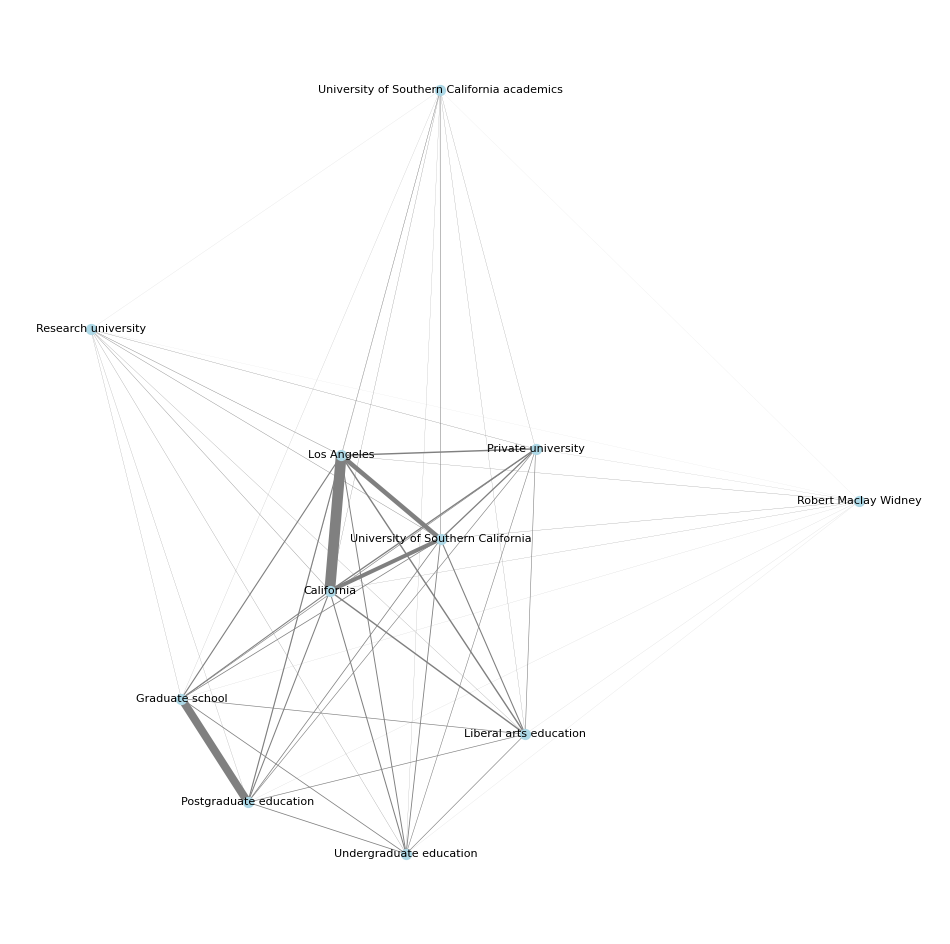

In [186]:

plt.figure(figsize=(12, 12))  # Adjust figure size as needed

pos = nx.spring_layout(article_projection)  # You can experiment with different layout algorithms

# Draw nodes
nx.draw_networkx_nodes(article_projection, pos, node_size=50, node_color="lightblue")

# Draw edges with weights as thickness, but scale down the weights
edge_widths = [d['weight'] / 100 for (u, v, d) in article_projection.edges(data=True)]  # Divide by a scaling factor (e.g., 5)
nx.draw_networkx_edges(article_projection, pos, width=edge_widths, edge_color="gray")

# Draw labels (optional, might be cluttered for large graphs)
nx.draw_networkx_labels(article_projection, pos, font_size=8)

plt.axis("off")
plt.show()


# On Your Own
1. Make a list of 10 wikipedia articles of your interest.
- Draw a hyperlink network.
- Draw a coauthorship network.
  
2. Select an article about a recent event.
- How does the article revision activity change?
- Change the window of moving average so that it makes a sense. For example, for an event a year ago, 30-day moving average would be fine. for an event a week ago, 1-day (or even shorter) might work just as fine.